# Subreddit Classification Using Language Processing
## Part 4 of 4: Modeling

#### Notebooks
- [01_data_collection](./01_data_collection.ipynb)
- [02_eda_and_cleaning](./02_eda_and_cleaning.ipynb)
- [03_visualizing](./03_visualizing.ipynb)
- [04_modeling](./04_modeling.ipynb)

#### This Notebook's Contents
- [Model Setup](#Model-Setup)
- [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)
- [Logistic Regression](#Logistic-Regression)
- [Logistic Regression Coefficients](#Logistic-Regression-Coefficients)
- [Conclusions](#Conclusions)

*NOTE: 'Data Science' may be abbrebiated to DS below. 'Artificial Intelligence' may be abbreviated to AI below.*

# Model Setup

In [1]:
# Import required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import recall_score, precision_score

import re 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import sklearn
sklearn.set_config(display='diagram')

# Hide non-critical warnings appearing in Jupyter notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import combined subreddit data.
df = pd.read_csv('../data/combined_cleaned_ai_ds.csv')

In [3]:
# Check the shape of the dataframe.
df.shape

(9431, 9)

In [4]:
# Assign text data to X.
X = df['all_text']

# Assign target feature to y.
y = df['data_science']

# Train/test split X and y.
X_train, X_test, y_train, y_test, = train_test_split(X, y, stratify=y, random_state=42)

In [5]:
# Display the shape of X_train.
X_train.shape

(7073,)

In [6]:
# Display the shape of y_train.
y_train.shape

(7073,)

In [7]:
# Display the shape of X_test.
X_test.shape

(2358,)

In [8]:
# Display the shape of y_test.
y_test.shape

(2358,)

## Create stemming and lemmatizing preprocessor functions

In [9]:
# Define a function that lower-cases, splits, and lemmatizes text.
def split_into_lems(text):
    """
    (str) -> str
    Returns a string of lower-case, lemmatized words separted by spaces.
    """
    # Lowercase the text.
    text = text.lower()
    # Instantiate a WordNetLemmatizer.
    lem = WordNetLemmatizer()
    # Return a string of all the lemmatized words separated by spaces.
    return ' '.join([lem.lemmatize(word) for word in text.split()])  

In [10]:
# Define a function that lower-cases, splits, and stems text.
def split_into_stems(text):
    """
    (str) -> str
    Returns a string of lower-case, stemmmed words separted by spaces.
    """
    # Lowercase the text.
    text = text.lower()
    # Instantiate a PorterStemmer.
    stem = PorterStemmer()
    # Return a string of all the stemmed words separated by spaces.
    return ' '.join([stem.stem(word) for word in text.split()])  

## Create custom stop words

In [11]:
# Created custom stop words.
my_stop_words = text.ENGLISH_STOP_WORDS.union([
    'amp', '’m', "'d", '‘d', 'don', "'ll", "'re", '’ve', "n't", '‘s', '’ll', "'ve", 'say', 
    '’s', 'n’t', "'m", '’d', "'s", 've', '‘ve', '‘m', '‘re', '’re', 'n‘t', 'ca', '‘ll', 
    'll', 'like', 'thanks', 'hi', 'lot'])

# Multinomial Naive Bayes

In [12]:
# Instantiate a pipeline using CountVectorizer and MulitnomialNB.
pipe_nb = make_pipeline(
    CountVectorizer(stop_words=my_stop_words), 
    MultinomialNB()
)

# More parameters were searched than those shown here, these performed the best.
# Set params for GridSearchCV to iterate through.
params_nb = {
    'multinomialnb__alpha': [2],
    'countvectorizer__ngram_range': [(1, 3)],
    'countvectorizer__max_df': [0.50],
    'countvectorizer__min_df': [2],
    'countvectorizer__preprocessor': [None]
}

# Instantiate GridSearchCV using the pipe and param objects.
grid_nb = GridSearchCV(pipe_nb, param_grid=params_nb, cv=10, n_jobs=-1)

# Fit the GridSearchCV object to the training data.
grid_nb.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words=frozenset({"'d",
                                                                              "'ll",
                                                                              "'m",
                                                                              "'re",
                                                                              "'s",
                                                                              "'ve",
                                                                              'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                                              'alone',
                                                                              'along',
                                                                              'already',
                                                                              'also',
                                                                              'although',
                                                                              'always',
                                                                              'am',
                                                                              'among',
                                                                              'amongst',
                                                                              'amoungst',
                                                                              'amount',
                                                                              'amp',
                                                                              'an',
                                                                              'and', ...}))),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.5],
                         'countvectorizer__min_df': [2],
                         'countvectorizer__ngram_range': [(1, 3)],
                         'countvectorizer__preprocessor': [None],
                         'multinomialnb__alpha': [2]})

In [13]:
# Display the best parameters from the GridSearch.
grid_nb.best_params_

{'countvectorizer__max_df': 0.5,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 3),
 'countvectorizer__preprocessor': None,
 'multinomialnb__alpha': 2}

In [14]:
# Calculate the model's test score and save to a variable.
nb_test = round(grid_nb.score(X_test, y_test) * 100, 2)

In [15]:
# Calculate the model's training score and save to a variable.
nb_train = round(grid_nb.score(X_train, y_train) * 100, 2)

In [16]:
print(f'MultinomialNB with CountVectorizer Testing Accuracy: {nb_test}%.')
print(f'MultinomialNB with CountVectorizer Training Accuracy: {nb_train}%.')

MultinomialNB with CountVectorizer Testing Accuracy: 90.67%.
MultinomialNB with CountVectorizer Training Accuracy: 95.53%.


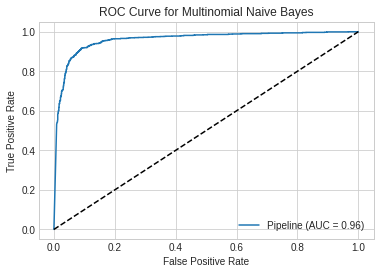

In [17]:
# Plot the ROC Curve for MultinomialNB.
plot_roc_curve(grid_nb.best_estimator_, X_test, y_test)
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve for Multinomial Naive Bayes');

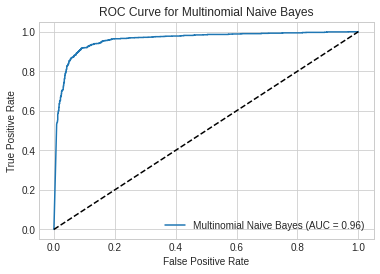

In [18]:
# Plot the ROC Curve for MultinomialNB.
# Override the legend with the correct description.
plot_roc_curve(grid_nb.best_estimator_, X_test, y_test)
plt.plot([0,1], [0,1], 'k--')
plt.legend(labels=['Multinomial Naive Bayes (AUC = 0.96)'])
plt.title('ROC Curve for Multinomial Naive Bayes');

# Logistic Regression

In [19]:
# Instantiate a pipeline using TfidfVectorizer and Logistic Regression.
pipe_logr = make_pipeline(
    TfidfVectorizer(stop_words=my_stop_words), 
    LogisticRegression(max_iter=10_000))

# More parameters were searched than those shown here, these performed the best.
# Set params for GridSearchCV to iterate through.
params_logr = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': [2],
    'logisticregression__solver': ['liblinear'],
    'tfidfvectorizer__ngram_range': [(1, 3)],
    'tfidfvectorizer__max_df': [0.50],
    'tfidfvectorizer__min_df': [2],
    'tfidfvectorizer__preprocessor': [split_into_stems]
}

# Instantiate GridSearchCV using the pipe and param objects.
grid_logr = GridSearchCV(pipe_logr, param_grid=params_logr, cv=10, n_jobs=-1)

# Fit the GridSearchCV object to the training data.
grid_logr.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=frozenset({"'d",
                                                                              "'ll",
                                                                              "'m",
                                                                              "'re",
                                                                              "'s",
                                                                              "'ve",
                                                                              'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                                              'alone',
                                                                              'along',
                                                                              'already',
                                                                              'also',
                                                                              'although',
                                                                              'always',
                                                                              'am',
                                                                              'among',
                                                                              'amongst',
                                                                              'amoungst',
                                                                              'amount',
                                                                              'amp',
                                                                              'an',
                                                                              'and', ...}))),
                                       ('logisticr...n',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [2],
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['liblinear'],
                         'tfidfvectorizer__max_df': [0.5],
                         'tfidfvectorizer__min_df': [2],
                         'tfidfvectorizer__ngram_range': [(1, 3)],
                         'tfidfvectorizer__preprocessor': [<function split_into_stems at 0x7f07dd2b77a0>]})

In [20]:
# Display the best parameters from the GridSearch.
grid_logr.best_params_

{'logisticregression__C': 2,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear',
 'tfidfvectorizer__max_df': 0.5,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 3),
 'tfidfvectorizer__preprocessor': <function __main__.split_into_stems(text)>}

In [21]:
# Calculate the model's test score and save to a variable.
logr_test = round(grid_logr.score(X_test, y_test) * 100, 2)

In [22]:
# Calculate the model's training score and save to a variable.
logr_train = round(grid_logr.score(X_train, y_train) * 100, 2)

In [23]:
print(f'Logistic Regression with TfidfVectorizer and Stemming Testing Accuracy: {logr_test}%') 
print(f'Logistic Regression with TfidfVectorizer and Stemming Training Accuracy: {logr_train}%')

Logistic Regression with TfidfVectorizer and Stemming Testing Accuracy: 92.66%
Logistic Regression with TfidfVectorizer and Stemming Training Accuracy: 97.85%


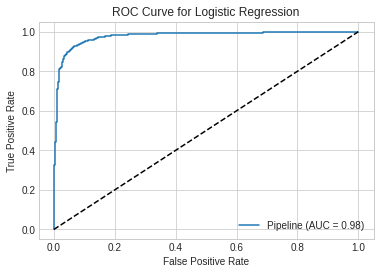

In [24]:
# Plot the ROC Curve for Logistic Regression.
plot_roc_curve(grid_logr.best_estimator_, X_test, y_test)
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve for Logistic Regression');

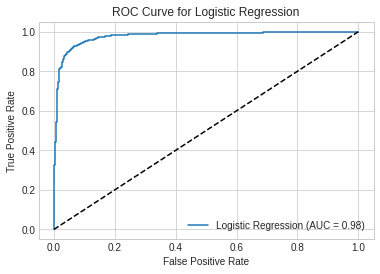

In [25]:
# Plot the ROC Curve for Logistic Regression.
# Override the legend with the correct description.
plot_roc_curve(grid_logr.best_estimator_, X_test, y_test)
plt.plot([0,1], [0,1], 'k--')
plt.legend(labels=['Logistic Regression (AUC = 0.98)'])
plt.title('ROC Curve for Logistic Regression');

# Logistic Regression Coefficients

In [26]:
# Extract amd save the word stem coefficients from the model.
word_coefs = grid_logr.best_estimator_.named_steps['logisticregression'].coef_[0]

# Extract amd save the word stems from the model.
words = grid_logr.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()

In [27]:
# Convert the words and word coefficients to a dataframe.
word_coef_df = pd.DataFrame({'Coefficients': word_coefs}, index=words)

In [28]:
# Sort the dataframe by coefficients.
word_coef_df = word_coef_df.sort_values(by='Coefficients', ascending=False)

# Display the dataframe.
word_coef_df

,Coefficients
data,11.580135
data scienc,7.177819
scienc,6.185033
ds,4.545478
statist,3.880717
...,...
human,-4.049954
artifici intellig,-4.444164
artifici,-5.326601
intellig,-5.409287


In [29]:
# Extract and save the largest 5 word coefficients.
word_coef_df_lg_5 = word_coef_df.nlargest(8, 'Coefficients')

# Extract and save the smallest 5 word coefficients.
word_coef_df_sm_5 = word_coef_df.nsmallest(8, 'Coefficients')

# Concatenate the largest and smallest word coefficients.
word_coef_top_10 = pd.concat([word_coef_df_lg_5, word_coef_df_sm_5])

# Sort the dataframe by coefficients.
word_coef_top_10 = word_coef_top_10.sort_values(by='Coefficients')

# Display the dataframe.
word_coef_top_10

,Coefficients
ai,-18.493182
intellig,-5.409287
artifici,-5.326601
artifici intellig,-4.444164
human,-4.049954
paper,-3.130150
robot,-2.861626
agi,-2.765694
job,3.082143
data scientist,3.336373


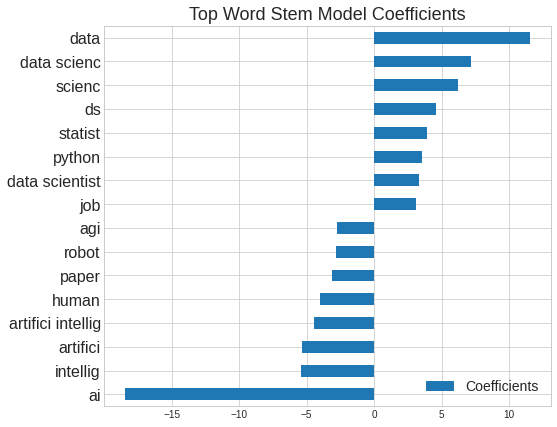

In [30]:
# Plot the datatframe of the top 10 word and their coefficients.
word_coef_top_10.plot(kind = 'barh', figsize=(8,7))
plt.title('Top Word Stem Model Coefficients', fontsize=18)
plt.yticks(fontsize=16)
plt.legend(fontsize=14, loc='lower right');

The model predicted 1 for data science, and 0 for artificial intelligence. The word stems with positive coefficients exerted more influence over a data-science classification, while the word stems with negative coefficients exerted more influence over an artificial intelligence classification.

In [31]:
# Use the best logistic regression estimator to predict y.
# Save to a variable.
y_preds = grid_logr.predict(X_test)

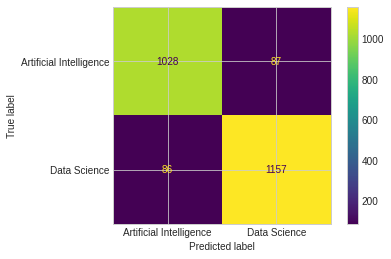

In [32]:
# Plot a confusion matrix.
plot_confusion_matrix(
    grid_logr, 
    X_test, 
    y_test, 
    display_labels=['Artificial Intelligence', 'Data Science']
);

In [33]:
# Calculate the model's recall and save to a variable.
recall = round(recall_score(y_test, y_preds) * 100, 2)
print(f"The best model's recall score is {recall}%.")

The best model's recall score is 93.08%.


In [34]:
# Calculate the model's precision and save to a variable.
precision = round(precision_score(y_test, y_preds) * 100, 2)

print(f"The best model's precision score is {precision}%.")

The best model's precision score is 93.01%.


# Conclusions

The optimal classifier for subreddit post classification was Logistic Regression with TfdifVectorizer. It achieved an accuracy score of 92.66% on the test data, with a recall score of 93.08% and a precision of 93.01%. The model was slightly overfit with a training accuracy of 97.85%.

The benefit of logistic regression is that interpretable word coefficients were able to be extracted and visualized. 

A performance boost was was observed when posts with missing text were dropped. This could be explained by more text conveying a stronger signal in an NLP model. It might also be the case that posts with title text only tended to be less relevant.

## Possible Next Steps
- Continue to test the model’s bias and variance by testing it on new data.
- Further validate the model on new posts.
- Explore other machine learning-related subreddits.